In [1]:
# Standard numerical and data manipulation libraries
import numpy as np
import pandas as pd
import math

# Scientific computing and machine learning libraries
from scipy.spatial import ConvexHull
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.decomposition import PCA

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MultipleLocator

# Set a consistent style for all plots for better aesthetics
sns.set_style("whitegrid")
plt.rcParams.update({
    'font.size': 12,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'figure.dpi': 150, # High resolution for plots
    'axes.edgecolor': 'black', # Ensure axis lines are visible
    'axes.linewidth': 1.5 # Thicker axis lines
})
plt.rcParams['figure.figsize'] = (10, 6) # Default figure size

# Set a random seed for reproducibility across all random operations
RANDOM_SEED = 0
np.random.seed(RANDOM_SEED)

Helper Functions

In [2]:
def point_in_hull(point, hull, tolerance=1e-12):
    """
    Checks if a given point is inside or on the boundary of a convex hull.

    Args:
        point (np.array): The point (coordinates) to check.
        hull (scipy.spatial.ConvexHull): The ConvexHull object, typically
                                         created from a set of points.
        tolerance (float): A small numerical tolerance. Points are considered
                           inside if their distance to any hyperplane of the
                           hull is less than or equal to this tolerance.

    Returns:
        bool: True if the point is inside or on the hull, False otherwise.
    """
    # For a point to be inside the hull, its signed distance to all
    # hyperplanes defining the hull must be non-positive (<= tolerance).
    # hull.equations has shape (n_facets, n_dims + 1), where the last column
    # is the offset (b) for the equation Ax + b <= 0.
    return all(
        (np.dot(eq[:-1], point) + eq[-1] <= tolerance)
        for eq in hull.equations
    )

Load Data and Initial Data preprocessing

In [3]:
print("--- Data Loading and Initial Preprocessing ---")

# Load the training and testing datasets
try:
    dftest0 = pd.read_csv('data/testEgEf.txt')
    dftrain0 = pd.read_csv('data/trainEgEf.txt')
    print("Datasets 'testEgEf.txt' and 'trainEgEf.txt' loaded successfully.")
except FileNotFoundError:
    print("Error: One or both data files not found. Please ensure 'testEgEf.txt' and 'trainEgEf.txt'")
    print("are in the same directory as this Jupyter Notebook. Exiting data loading.")
    # In a production environment, you might want to exit or raise an error here.
    # For demonstration purposes, we'll create dummy data if files are missing.
    print("Creating dummy dataframes for demonstration purposes...")
    dummy_data = {
        'id': range(1, 201),
        'spacegroup': np.random.randint(1, 231, 200),
        'number_of_total_atoms': np.random.randint(20, 100, 200),
        'percent_atom_al': np.random.rand(200),
        'percent_atom_ga': np.random.rand(200),
        'percent_atom_in': np.random.rand(200),
        'lattice_vector_1_ang': np.random.rand(200) * 10 + 5,
        'lattice_vector_2_ang': np.random.rand(200) * 10 + 5,
        'lattice_vector_3_ang': np.random.rand(200) * 10 + 5,
        'lattice_angle_alpha_degree': np.random.rand(200) * 30 + 75,
        'lattice_angle_beta_degree': np.random.rand(200) * 30 + 75,
        'lattice_angle_gamma_degree': np.random.rand(200) * 30 + 75,
        'Ef': np.random.rand(200) * 0.5 + 0.1,
        'Eg': np.random.rand(200) * 4 + 1
    }
    dftrain0 = pd.DataFrame(dummy_data).iloc[:150] # 150 samples for train
    dftest0 = pd.DataFrame(dummy_data).iloc[150:]  # 50 samples for test
    print("Dummy data created and loaded.")


# Drop the 'Ef' column as the current analysis focuses on 'Eg' prediction
dftest = dftest0.drop("Ef", axis=1)
dftrain = dftrain0.drop("Ef", axis=1)

# Separate features (X) and target (y) for both training and testing sets.
# The 'id' column is dropped as it's an identifier, not a predictive feature.
X_train_raw = dftrain.drop(["id", "Eg"], axis=1)
y_train = np.asarray(dftrain['Eg']).astype('float') # Ensure target is float type

X_test_raw = dftest.drop(["id", "Eg"], axis=1)
y_test = np.asarray(dftest['Eg']).astype('float') # Ensure target is float type

print(f"Training data (features): {X_train_raw.shape}, Training data (target): {y_train.shape}")
print(f"Test data (features): {X_test_raw.shape}, Test data (target): {y_test.shape}")


--- Data Loading and Initial Preprocessing ---
Datasets 'testEgEf.txt' and 'trainEgEf.txt' loaded successfully.
Training data (features): (2400, 11), Training data (target): (2400,)
Test data (features): (600, 11), Test data (target): (600,)


Exploratory Data Analysis (EDA) Visualizations


--- Exploratory Data Analysis (EDA) ---


C:\Users\Administrator\AppData\Local\Temp\ipykernel_24716\2903043313.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Dataset')
C:\Users\Administrator\AppData\Local\Temp\ipykernel_24716\2903043313.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Dataset')


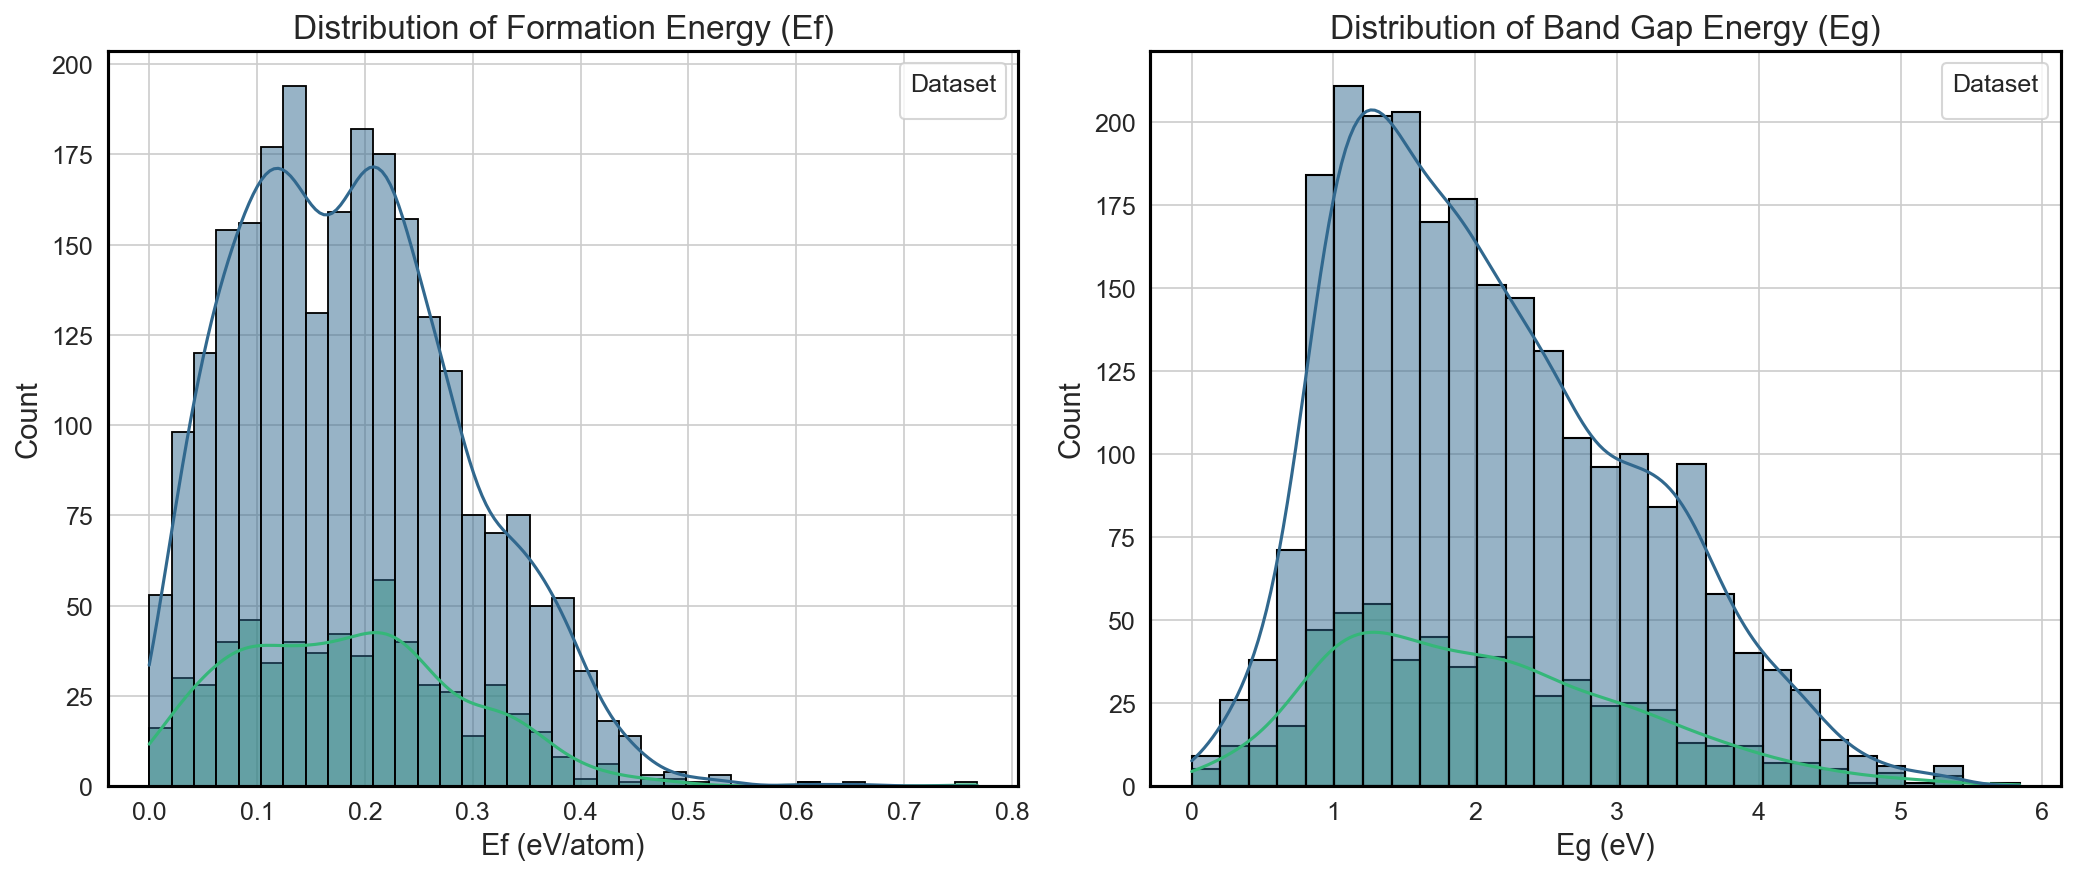

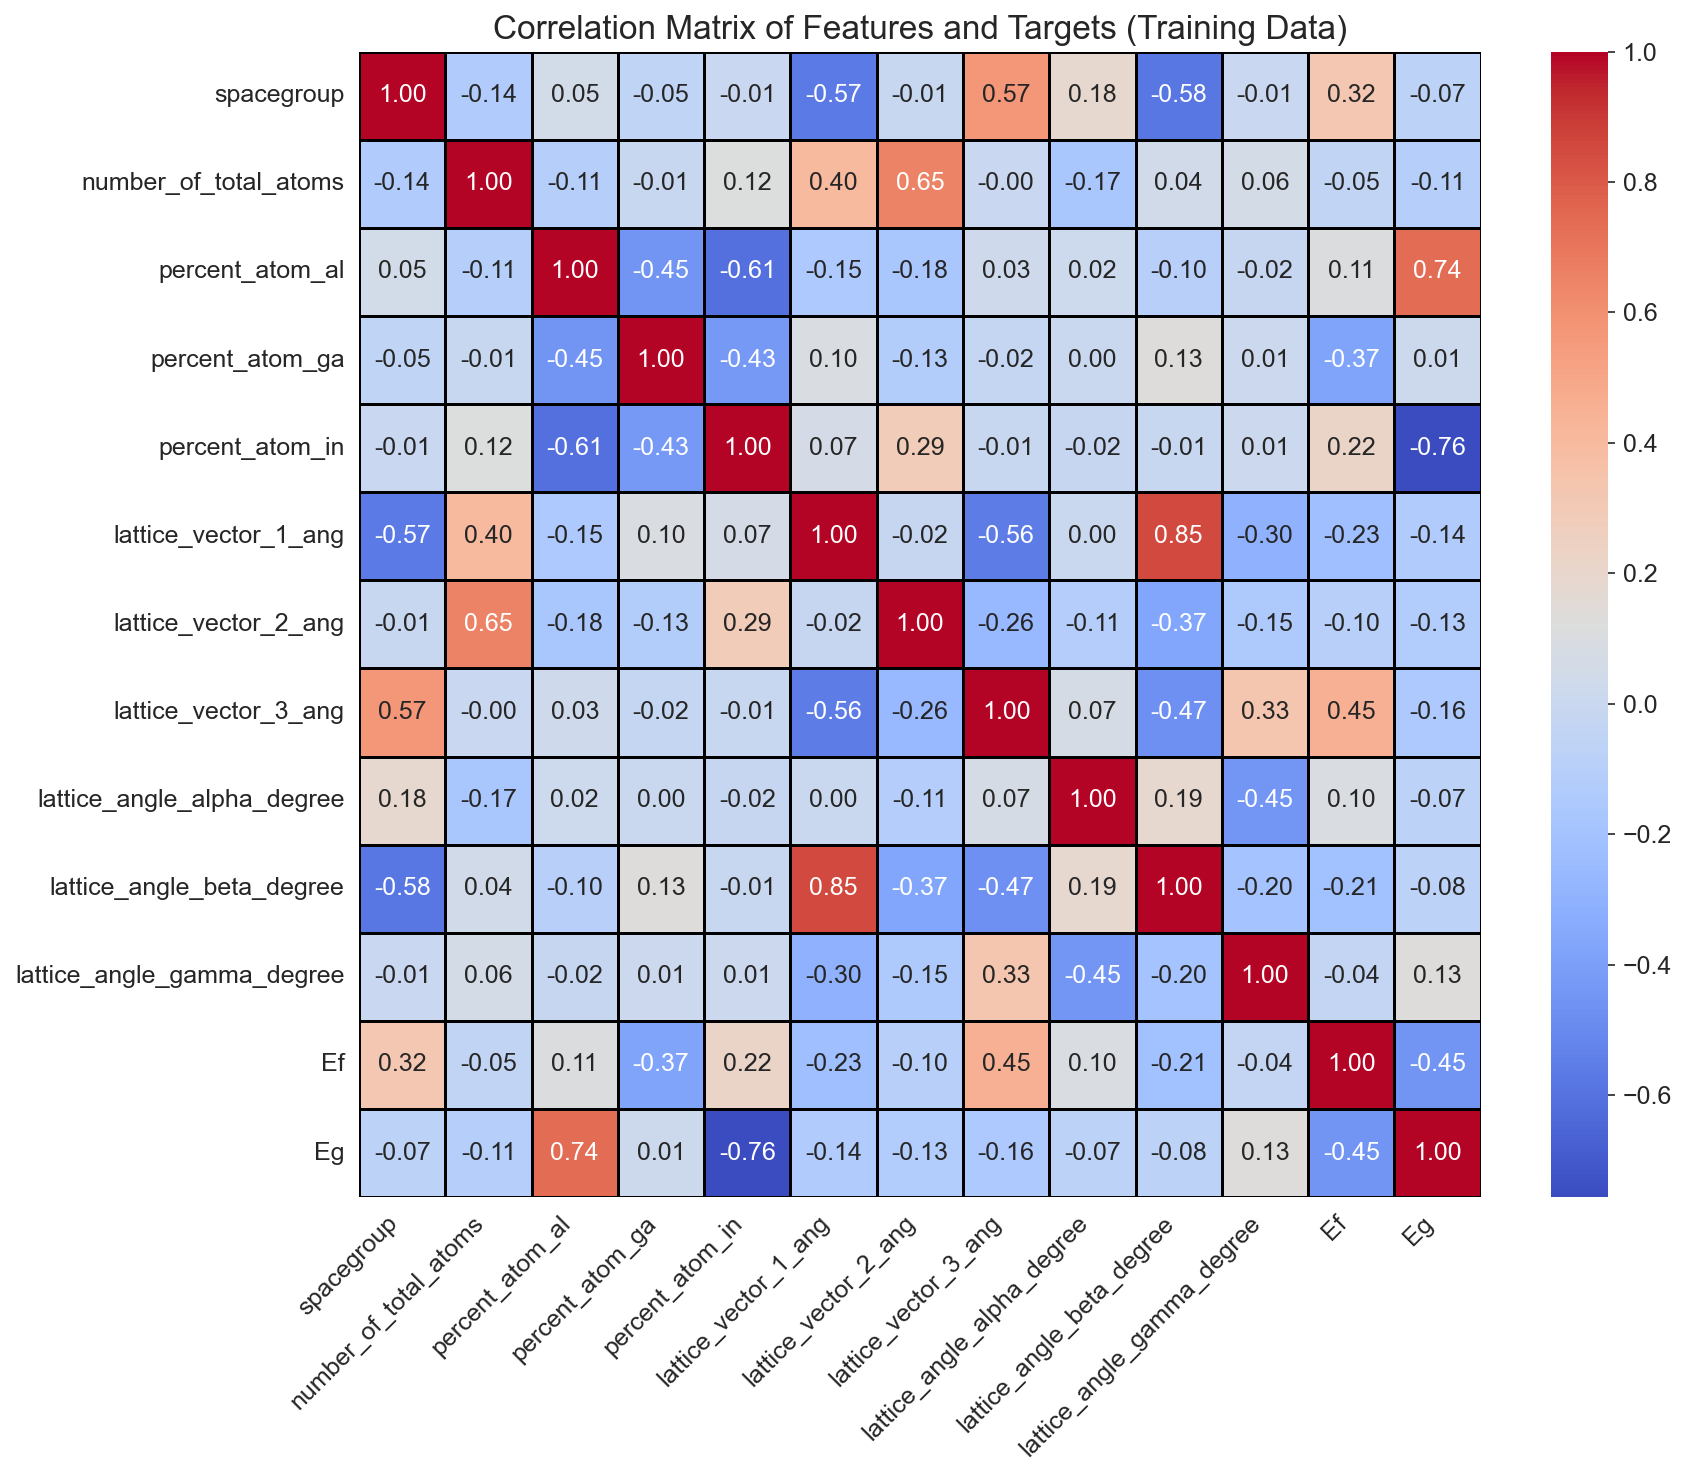

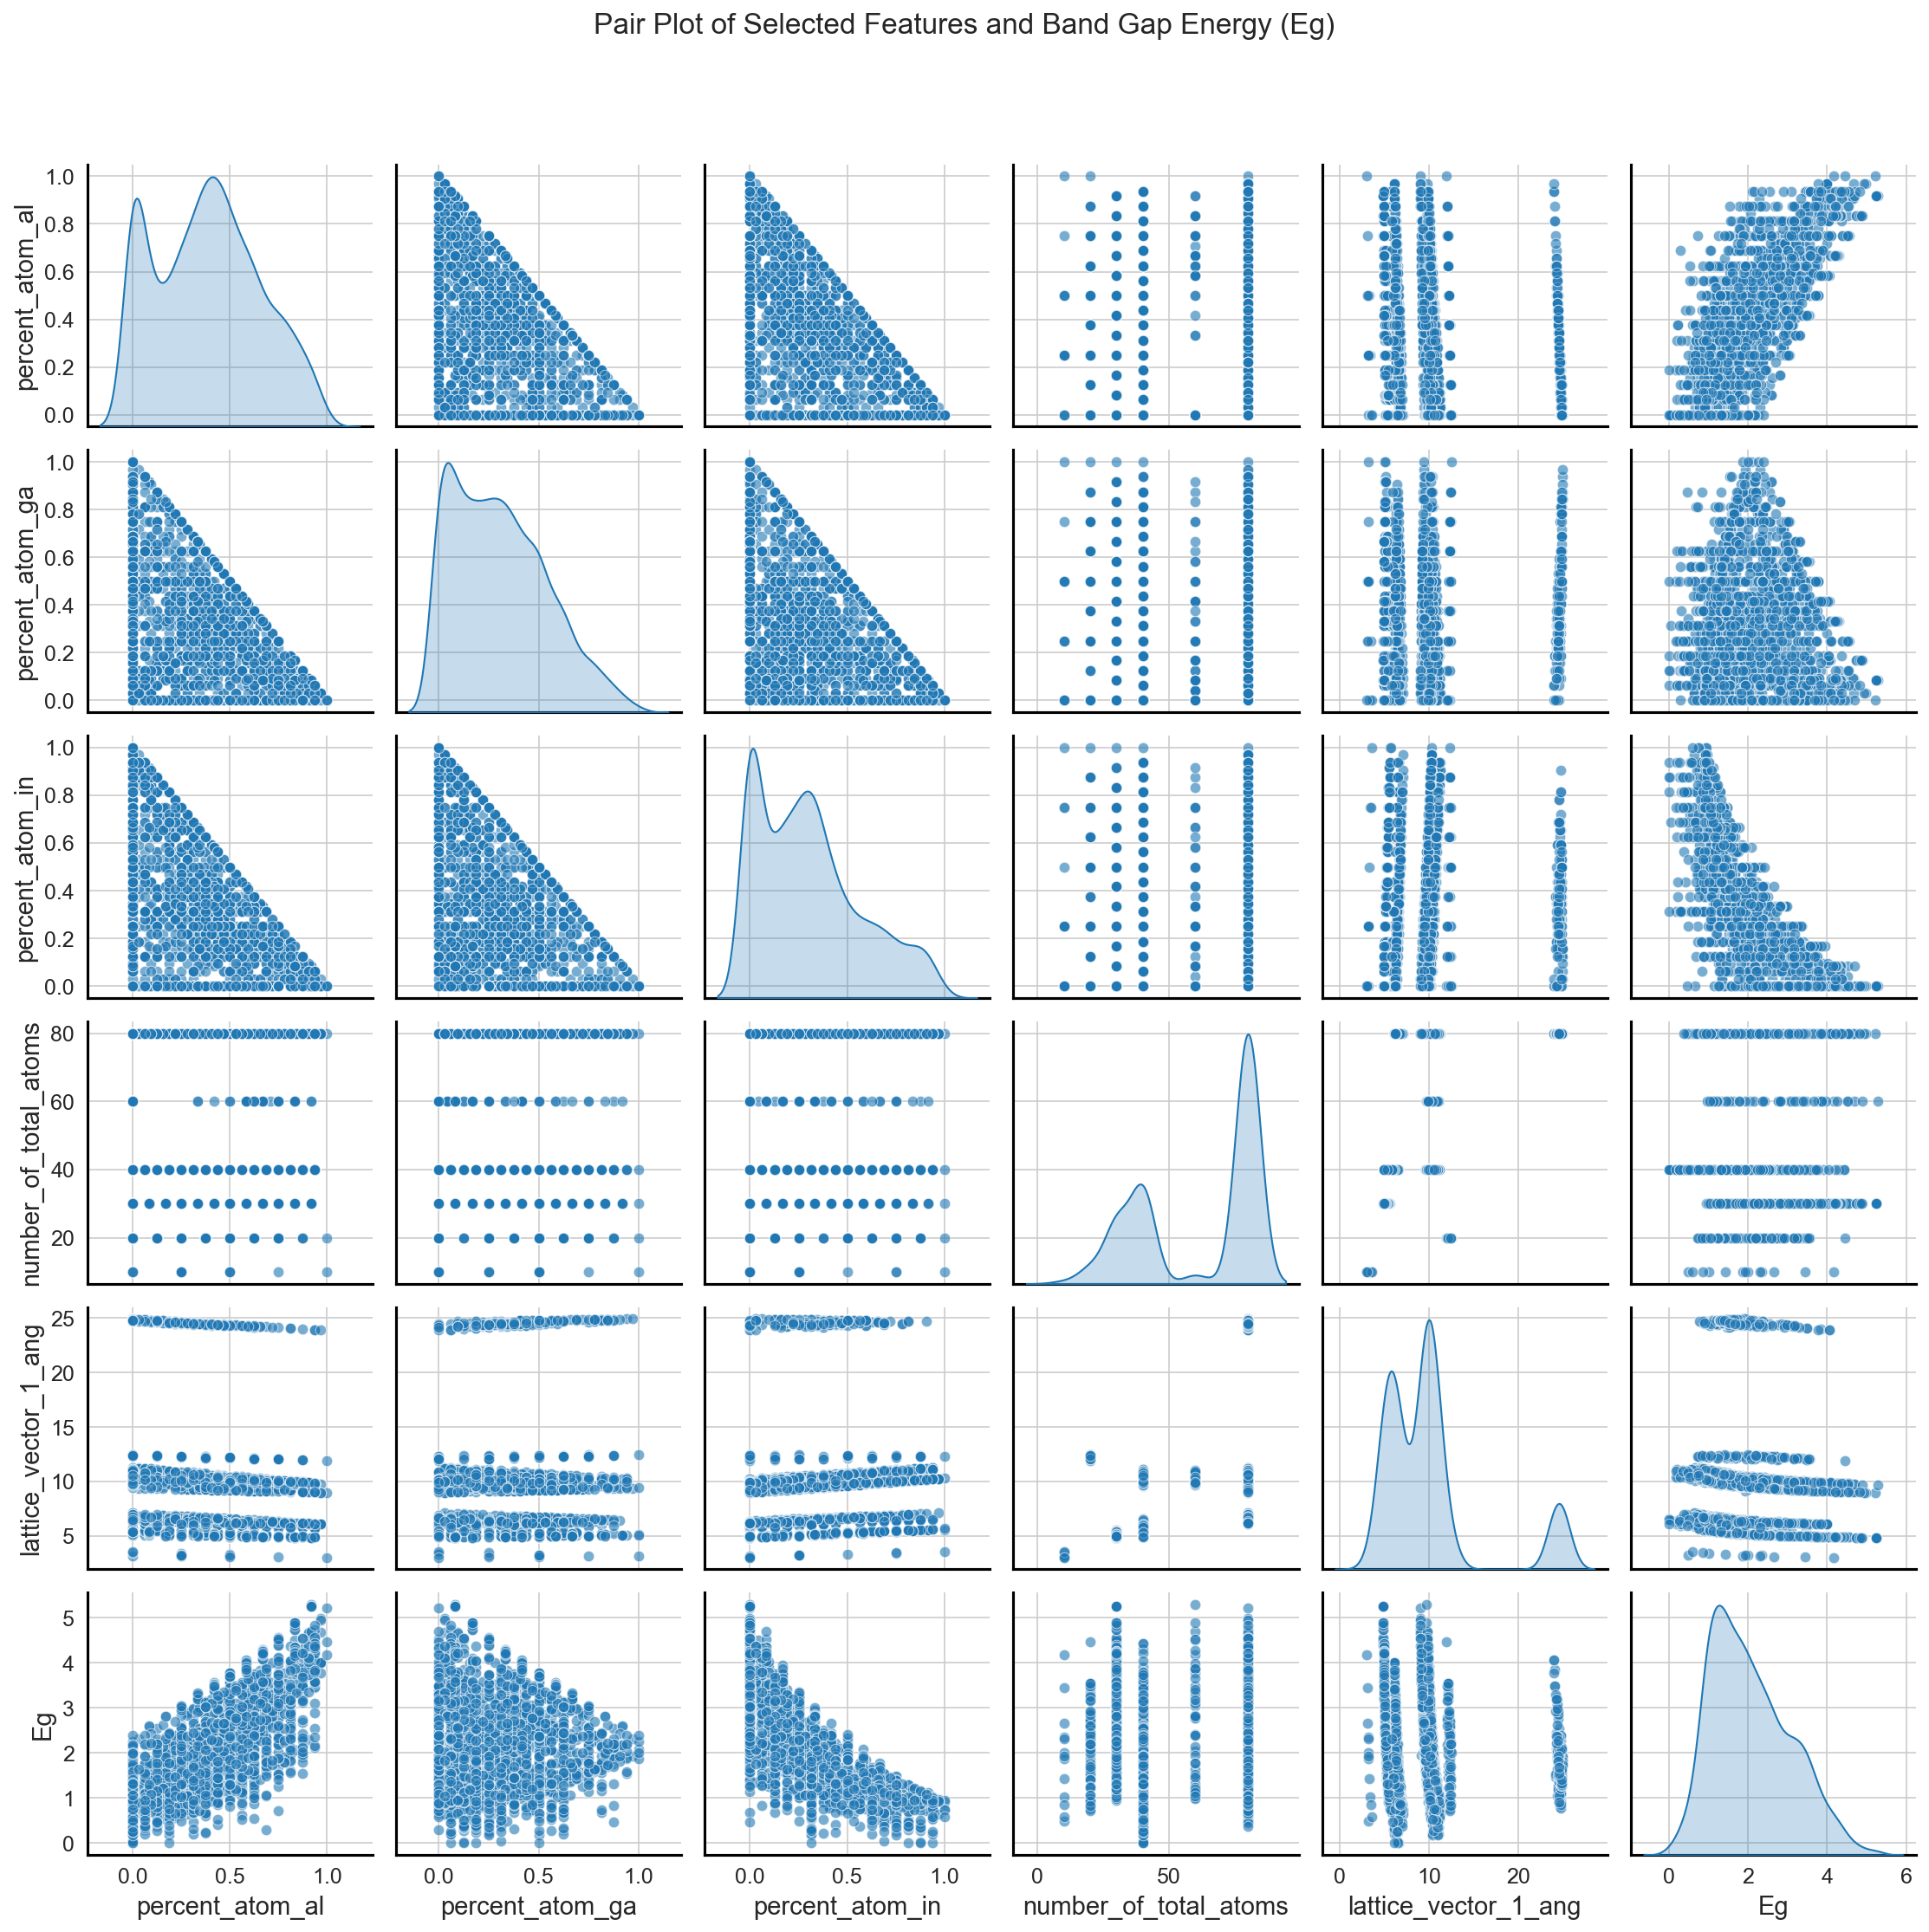

In [4]:
print("\n--- Exploratory Data Analysis (EDA) ---")

# Combine training and test data for unified plotting, adding a 'dataset' column
combined_data = pd.concat([dftrain0.assign(dataset='Train'), dftest0.assign(dataset='Test')])

# 4.1 Distribution of Formation Energy (Ef) and Band Gap Energy (Eg)
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(combined_data, x='Ef', hue='dataset', kde=True, palette='viridis', edgecolor='black')
plt.title('Distribution of Formation Energy (Ef)', fontsize=16)
plt.xlabel('Ef (eV/atom)', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.legend(title='Dataset')

plt.subplot(1, 2, 2)
sns.histplot(combined_data, x='Eg', hue='dataset', kde=True, palette='viridis', edgecolor='black')
plt.title('Distribution of Band Gap Energy (Eg)', fontsize=16)
plt.xlabel('Eg (eV)', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.legend(title='Dataset')

plt.tight_layout()
plt.show()

# 4.2 Correlation Heatmap of Features and Targets
# Drop 'id' before calculating correlation as it's not a meaningful feature
plt.figure(figsize=(12, 10))
correlation_matrix = dftrain0.drop('id', axis=1).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, linecolor='black')
plt.title('Correlation Matrix of Features and Targets (Training Data)', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 4.3 Pair Plot for Selected Key Features and Target
# A pair plot helps visualize relationships between pairs of variables.
# Selecting a subset of features to keep the plot readable.
selected_features_for_pairplot = [
    'percent_atom_al', 'percent_atom_ga', 'percent_atom_in',
    'number_of_total_atoms', 'lattice_vector_1_ang', 'Eg'
]
sns.pairplot(dftrain0[selected_features_for_pairplot], diag_kind='kde', plot_kws={'alpha': 0.6, 'edgecolor': 'w'})
plt.suptitle('Pair Plot of Selected Features and Band Gap Energy (Eg)', y=1.02, fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.98]) # Adjust layout to prevent title overlap
plt.show()

SVR Model Training and Prediction

In [5]:
print("\n--- SVR Model Training and Prediction ---")

# Define the SVR pipeline: first scale the data, then apply SVR.
# This ensures that scaling is consistently applied during cross-validation
# and to new data.
steps = [('scaler', StandardScaler()), ('SVM', SVR())]
pipeline = Pipeline(steps)

# Define the parameter grid for GridSearchCV.
# The original code uses fixed values, but GridSearchCV is set up for hyperparameter tuning.
# For demonstration, we keep the original fixed values.
param_grid = {
    'SVM__C': [100],          # Regularization parameter
    'SVM__gamma': ['auto'],   # Kernel coefficient ('auto' uses 1 / n_features)
    'SVM__kernel': ['rbf'],   # Radial Basis Function kernel
    'SVM__epsilon': [0.001]   # Epsilon-tube within which no penalty is associated in the training loss function
}

# Setup GridSearchCV for hyperparameter tuning and model selection.
# cv=5: 5-fold cross-validation.
# verbose=1: Prints progress messages.
# n_jobs=-1: Uses all available CPU cores for parallel processing, improving efficiency.
grid = GridSearchCV(pipeline, param_grid, cv=5, verbose=1, n_jobs=-1)

print("Fitting SVR model with GridSearchCV (this may take a moment)...")
# Fit the GridSearchCV object to the raw training data.
# The pipeline's StandardScaler will handle the scaling internally.
grid.fit(X_train_raw, y_train)
print("Model fitting complete.")

# Display the best parameters found by GridSearchCV and the corresponding cross-validation score.
print(f"\nBest parameters found: {grid.best_params_}")
print(f"Best cross-validation R^2 score: {grid.best_score_:.4f}")

# Make predictions on the unseen test set using the best model from GridSearchCV.
# Again, the pipeline handles the scaling of X_test_raw.
y_predicted = grid.predict(X_test_raw)

# Calculate the absolute prediction error for evaluation.
prederror = np.abs(y_predicted - y_test)
print(f"Mean Absolute Error (MAE) on the test set: {np.mean(prederror):.4f} eV/atom")


--- SVR Model Training and Prediction ---
Fitting SVR model with GridSearchCV (this may take a moment)...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Model fitting complete.

Best parameters found: {'SVM__C': 100, 'SVM__epsilon': 0.001, 'SVM__gamma': 'auto', 'SVM__kernel': 'rbf'}
Best cross-validation R^2 score: 0.9456
Mean Absolute Error (MAE) on the test set: 0.1270 eV/atom


Model Performance Visualizations


--- Model Performance Visualizations ---


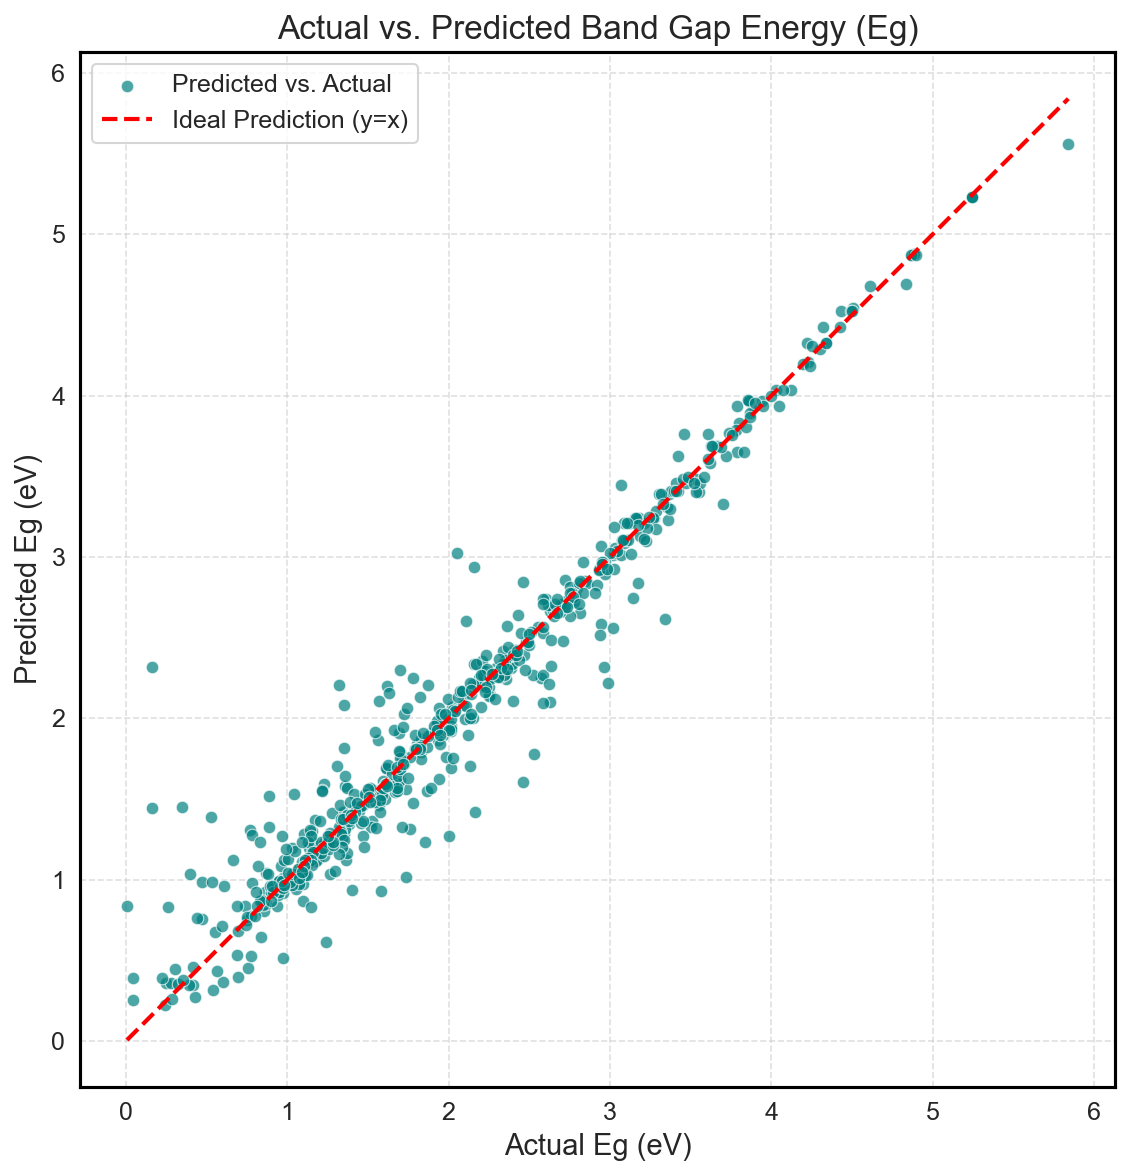

In [6]:
print("\n--- Model Performance Visualizations ---")

# 6.1 Actual vs. Predicted Band Gap Energy (Eg)
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_predicted, alpha=0.7, edgecolors='w', linewidth=0.5, color='teal', label='Predicted vs. Actual')
# Plot a y=x line for ideal prediction
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)],
         'r--', lw=2, label='Ideal Prediction (y=x)')
plt.xlabel('Actual Eg (eV)', fontsize=14)
plt.ylabel('Predicted Eg (eV)', fontsize=14)
plt.title('Actual vs. Predicted Band Gap Energy (Eg)', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.gca().set_aspect('equal', adjustable='box') # Ensures the plot is square
plt.tight_layout()
plt.show()

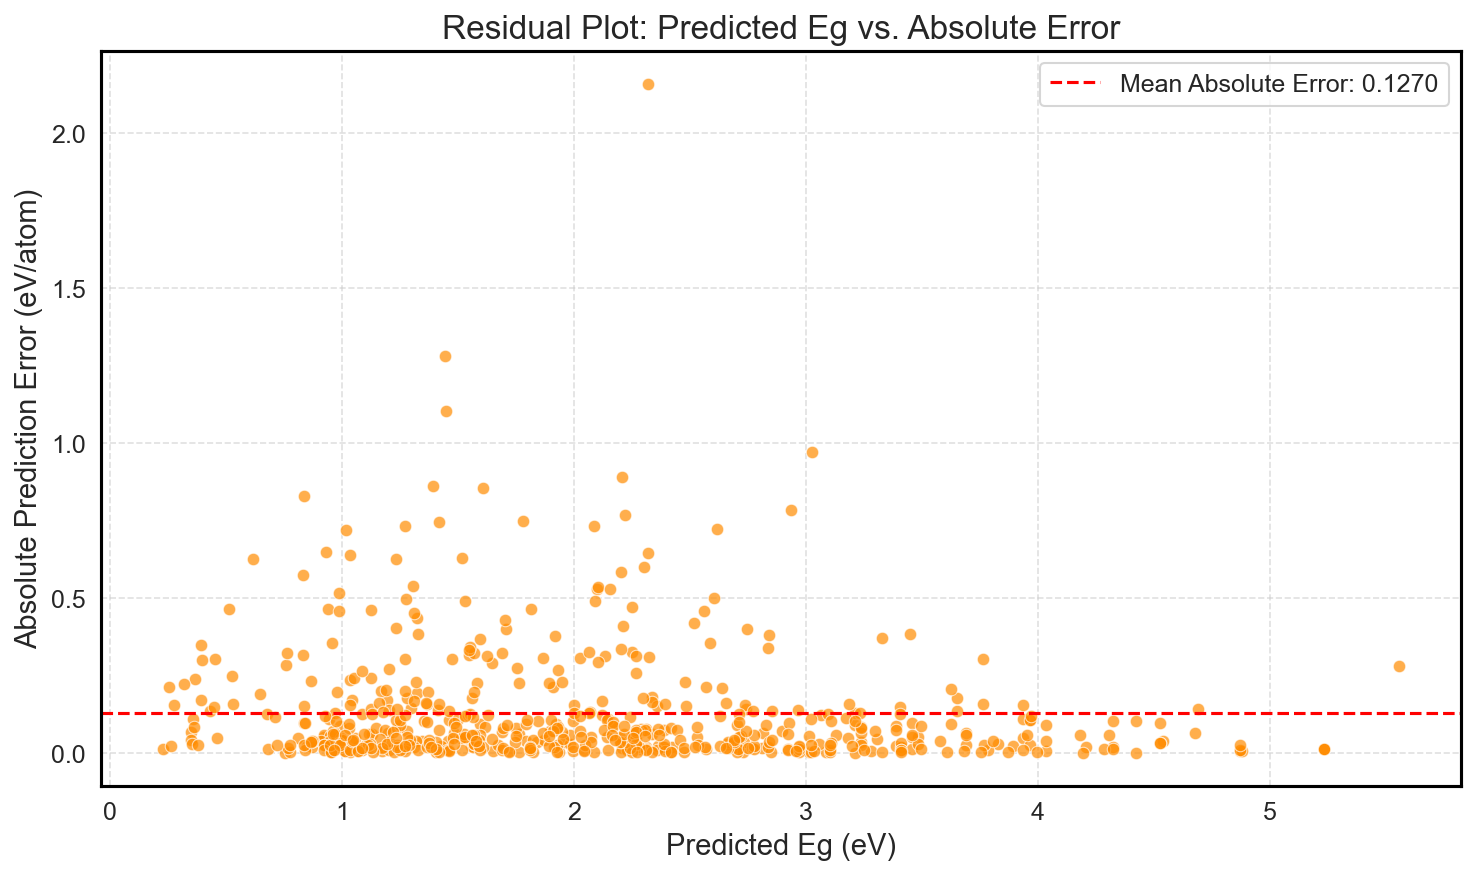

In [7]:
# 6.2 Residual Plot: Predicted Eg vs. Absolute Prediction Error
plt.figure(figsize=(10, 6))
plt.scatter(y_predicted, prederror, alpha=0.7, edgecolors='w', linewidth=0.5, color='darkorange')
plt.xlabel('Predicted Eg (eV)', fontsize=14)
plt.ylabel('Absolute Prediction Error (eV/atom)', fontsize=14)
plt.title('Residual Plot: Predicted Eg vs. Absolute Error', fontsize=16)
# Add a horizontal line for the mean absolute error
plt.axhline(y=np.mean(prederror), color='red', linestyle='--',
            label=f'Mean Absolute Error: {np.mean(prederror):.4f}')
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Data Stacking and PCA Transformation


--- Data Stacking and PCA Transformation ---
Shape of data after stacking and PCA transformation: (600, 19)
Columns in trainconvexhullF: Original 11 features, 1 error, 1 actual Eg, 1 predicted Eg, 5 PCA components.


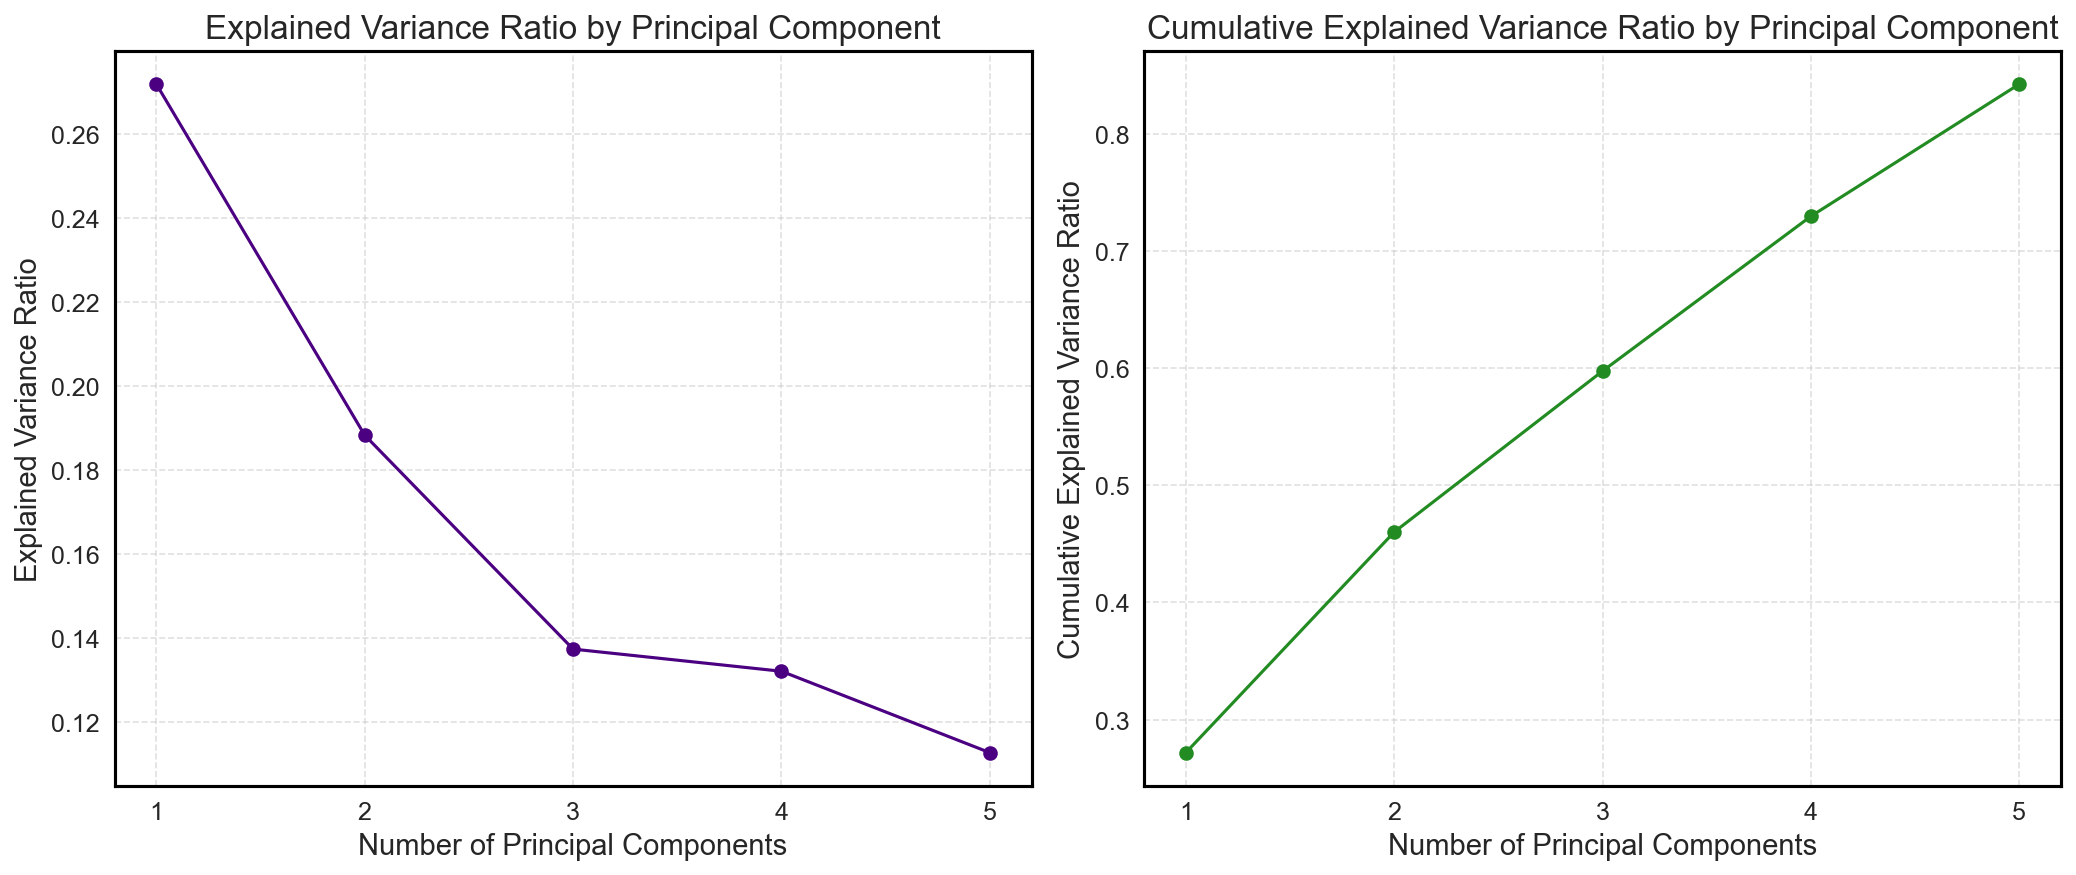

In [8]:
print("\n--- Data Stacking and PCA Transformation ---")

# First, scale the raw test features. This scaler is separate from the SVR pipeline's scaler
# because PCA needs to be applied to the features for the Convex Hull analysis.
# In a real application, this scaler should be fitted on training data and then transform test data.
# For consistency with the original code's implied logic (PCA on features that were scaled),
# we fit a new scaler here on X_train_raw and transform both train and test.
scaler_for_pca_features = StandardScaler()
X_train_scaled_for_pca = scaler_for_pca_features.fit_transform(X_train_raw)
X_test_scaled_for_pca = scaler_for_pca_features.transform(X_test_raw)

# Stack the data: scaled test features, prediction error, actual Eg, predicted Eg.
# This creates a comprehensive array for the Convex Hull analysis.
# The order of columns in `trainconvexhull10` will be:
# [scaled_feature_1, ..., scaled_feature_N, prederror, y_test, y_predicted]
stack1 = np.vstack((X_test_scaled_for_pca.T, prederror, y_test, y_predicted))
trainconvexhull10 = stack1.T # Transpose back to have samples as rows

# Apply Principal Component Analysis (PCA) to reduce the dimensionality of the features.
# PCA is fitted on the *scaled training features* and then used to transform *scaled test features*.
pca_on_features = PCA(n_components=5, random_state=RANDOM_SEED)
pca_on_features.fit(X_train_scaled_for_pca) # Fit PCA on the scaled training features
pca_transformed_test_features = pca_on_features.transform(X_test_scaled_for_pca) # Transform scaled test features

# Final data preparation: Horizontally stack the `trainconvexhull10` (which contains
# scaled test features, error, actual Eg, predicted Eg) with the PCA-transformed test features.
# This augments each sample with its 5 principal components.
trainconvexhullFint = np.hstack((trainconvexhull10, pca_transformed_test_features))

# Permute the final dataset randomly for robust splitting in the optimization step.
trainconvexhullF = np.random.RandomState(RANDOM_SEED).permutation(trainconvexhullFint)

print(f"Shape of data after stacking and PCA transformation: {trainconvexhullF.shape}")
print(f"Columns in trainconvexhullF: Original {X_test_raw.shape[1]} features, "
      f"1 error, 1 actual Eg, 1 predicted Eg, 5 PCA components.")


# 7.1 Visualization of PCA Explained Variance
# This plot helps determine how much variance each principal component captures.
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, pca_on_features.n_components_ + 1), pca_on_features.explained_variance_ratio_,
         marker='o', linestyle='-', color='indigo', markersize=6)
plt.title('Explained Variance Ratio by Principal Component', fontsize=16)
plt.xlabel('Number of Principal Components', fontsize=14)
plt.ylabel('Explained Variance Ratio', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(range(1, pca_on_features.n_components_ + 1))

plt.subplot(1, 2, 2)
plt.plot(range(1, pca_on_features.n_components_ + 1), np.cumsum(pca_on_features.explained_variance_ratio_),
         marker='o', linestyle='-', color='forestgreen', markersize=6)
plt.title('Cumulative Explained Variance Ratio by Principal Component', fontsize=16)
plt.xlabel('Number of Principal Components', fontsize=14)
plt.ylabel('Cumulative Explained Variance Ratio', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(range(1, pca_on_features.n_components_ + 1))
plt.tight_layout()
plt.show()

Convex Hull Optimization Function

In [9]:
print("\n--- Convex Hull Optimization ---")

def optimize_hull(data, n_iterations=2000, random_seed=RANDOM_SEED):
    """
    Optimizes a convex hull by iteratively refining the set of points
    that define the hull. The optimization aims to find a hull that
    encloses points with lower prediction errors, based on a custom cost function.

    Args:
        data (np.array): The input data array, which should include the features
                         (specifically the PCA components for hull definition),
                         prediction error, actual Eg, and predicted Eg.
                         Expected column order: [..., prederror, y_test, y_predicted, pca_comp1, ..., pca_comp5]
        n_iterations (int): The maximum number of iterations for the optimization process.
        random_seed (int): Seed for random number generation to ensure reproducibility
                           of data splitting within the optimization loop.

    Returns:
        tuple: A tuple containing:
            - train_data_for_hull (np.array): The final set of points used to define the hull.
            - test_data_for_hull (np.array): The portion of the initial data reserved for testing
                                            the hull's performance.
            - final_hull (scipy.spatial.ConvexHull): The final ConvexHull object.
            - cost_history (list): A list of cost function values at each iteration.
            - error_history (list): A list of average errors for points inside the hull
                                    at each iteration.
    """
    np.random.seed(random_seed) # Ensure reproducibility for splitting

    # Split the permuted data into an initial training set for the hull and a test set
    train_size = int(0.8 * len(data))
    trainconvexhullF = data
    trainconvexhull = trainconvexhullF[:train_size]      # Initial training data for hull
    trainconvexhulltest = trainconvexhullF[train_size:] # Test data for evaluating the hull

    Costlim = [] # Stores the cost function value for each iteration
    Errlim = []  # Stores the average error for points inside the hull for each iteration
    Costprog = [] # Stores the progressive best cost values
    Errprog = []  # Stores the progressive best error values
    trainconvexhull1 = trainconvexhull.copy() # This set of points dynamically changes
                                              # and is used to build the hull in each iteration.

    print(f"Starting Convex Hull optimization for up to {n_iterations} iterations...")

    for j in range(n_iterations):
        costsum = 0
        errsum = 0
        Ng = 0 # Counter for number of points found inside the current hull

        # Determine the subset of points to use for building the Convex Hull in this iteration.
        # This dynamic adjustment is based on the cost function's progress.
        if j == 0:
            # In the first iteration, use the entire initial training set for the hull
            hull_points_for_calc = trainconvexhull[:, -5:] # Using the last 5 columns (PCA components)
        else:
            # For subsequent iterations, dynamically adjust the size of the subset
            # based on the previous iteration's cost relative to the initial cost.
            if len(trainconvexhull1) > 25: # Only split if there are enough points
                if (1 / 3) * Costlim[0] < Costlim[j - 1] < 0.5 * Costlim[0]:
                    # If cost is moderately reduced, split off 10 points for testing
                    trainconvexhullint, testconvexhullint = train_test_split(
                        trainconvexhull1, test_size=10, random_state=random_seed
                    )
                elif Costlim[j - 1] < (1 / 3) * Costlim[0]:
                    # If cost is significantly reduced, split off fewer points (5)
                    trainconvexhullint, testconvexhullint = train_test_split(
                        trainconvexhull1, test_size=5, random_state=random_seed
                    )
                else:
                    # Otherwise, split off more points (20)
                    trainconvexhullint, testconvexhullint = train_test_split(
                        trainconvexhull1, test_size=20, random_state=random_seed
                    )
            else:
                # If the current set of points is small, use all of them for the hull
                trainconvexhullint = trainconvexhull1

            hull_points_for_calc = trainconvexhullint[:, -5:] # Use PCA components for hull calculation

        # Ensure there are enough points to form a 5D convex hull (at least 6 points)
        if len(hull_points_for_calc) < 6:
            print(f"Warning: Not enough points ({len(hull_points_for_calc)}) to form a 5D hull at iteration {j}. Stopping optimization.")
            # If hull cannot be formed, return the last valid state or initial state
            if j > 0:
                return trainconvexhull1, trainconvexhulltest, hull00, Costlim, Errlim
            else: # If it fails on the first iteration
                print("Error: Failed to form initial hull. Please check data or n_components for PCA.")
                return trainconvexhull, trainconvexhulltest, None, Costlim, Errlim # Return None for hull if not created

        try:
            hull00 = ConvexHull(hull_points_for_calc)
        except Exception as e:
            print(f"Error creating ConvexHull at iteration {j}: {e}. Skipping this iteration.")
            # If hull creation fails, append the last known cost/error or a placeholder
            if j > 0:
                Costlim.append(Costlim[-1])
                Errlim.append(Errlim[-1])
            else: # If it fails on the very first iteration
                Costlim.append(np.inf) # Indicate a very high cost
                Errlim.append(1.0) # Indicate a high error
            continue # Skip to the next iteration

        coststep = []
        ptconv = []      # Stores [error, actual_Eg, predicted_Eg] for points inside the hull
        ptconverr = []   # Stores PCA components for points inside the hull

        # Iterate through the *entire initial training set for the hull* (`trainconvexhull`)
        # to check which of these points fall inside the *currently defined hull* (`hull00`).
        for i in range(len(trainconvexhull)):
            if point_in_hull(trainconvexhull[i, -5:], hull00):
                errsum += trainconvexhull[i, -8] # Accumulate error for points inside the hull
                ptconv.append([trainconvexhull[i, -8], trainconvexhull[i, -7], trainconvexhull[i, -6]])
                ptconverr.append(trainconvexhull[i, -5:]) # Store PCA components of points inside

                # Calculate the cost contribution for the current point
                # Points with very low error (5th percentile) have 0 cost.
                # Higher errors contribute exponentially to the cost.
                if trainconvexhull[i, -8] <= np.percentile(trainconvexhull[:, -8], 5):
                    coststep.append(0.0)
                else:
                    coststep.append(math.exp(3.0 * trainconvexhull[i, -8]))
                Ng += 1 # Increment count of points inside the hull

        # Calculate the total cost and average error for the current iteration
        costsum = -Ng + np.sum(coststep) # Cost function: penalize number of points, reward low error
        Costlim.append(costsum)
        Errlim.append(errsum / Ng if Ng > 0 else 1.0) # Avoid division by zero if no points are inside

        # Update the set of points (`trainconvexhull1`) that will be used to build the hull
        # in the *next* iteration, based on whether the current iteration improved.
        if j > 0:
            if Costlim[j] < Costlim[j - 1] and Errlim[j] < Errlim[j - 1]:
                # If both cost and error improved, keep the refined set (`trainconvexhullint`)
                trainconvexhull1 = trainconvexhullint
                Costprog.append(Costlim[j])
                Errprog.append(Errlim[j])
            else:
                # If no improvement, add some points back from the `testconvexhullint`
                # (the points split off earlier in this iteration)
                if (1 / 3) * Costlim[0] < Costlim[j - 1] < 0.5 * Costlim[0]:
                    trainconvexhull1 = np.vstack((testconvexhullint[:6], trainconvexhullint))
                elif Costlim[j - 1] < (1 / 3) * Costlim[0]:
                    trainconvexhull1 = np.vstack((testconvexhullint[:3], trainconvexhullint))
                else:
                    trainconvexhull1 = np.vstack((testconvexhullint[:12], trainconvexhullint))

        # Early stopping conditions:
        # 1. Stop if the average error of points inside the hull drops below a threshold.
        if Errlim[j] < 0.022:
            trainconvexhull2 = trainconvexhullint # Store the state that achieved this low error
            print(f"Early stopping: Average error limit reached ({Errlim[j]:.4f} < 0.022) at iteration {j}.")
            return trainconvexhull2, trainconvexhulltest, hull00, Costlim, Errlim

        # 2. Stop if error is within a certain range of initial error and enough points are inside.
        if j > 0 and 0.65 * Errlim[0] < Errlim[j] < Errlim[0] and Ng > 50:
            if len(trainconvexhullint) < 60:
                print(f"Early stopping: Error within acceptable range and enough points ({Ng}) at iteration {j}.")
                # Recalculate the final hull using the points that were actually inside
                # the hull from the current iteration (`ptconverr`).
                if len(ptconverr) > 5: # Ensure enough points to form a 5D hull
                    final_hull = ConvexHull(np.array(ptconverr))
                    return trainconvexhullint, trainconvexhulltest, final_hull, Costlim, Errlim
                else:
                    print("Warning: Not enough points for a meaningful final hull, returning current hull.")
                    return trainconvexhullint, trainconvexhulltest, hull00, Costlim, Errlim

        # Print progress every 100 iterations
        if j % 100 == 0:
            print(f"Iteration {j}: Current Cost = {Costlim[j]:.2f}, Current Avg Error = {Errlim[j]:.4f}, Points in Hull = {Ng}")

    print("Convex Hull optimization finished (max iterations reached or stopped earlier).")
    # Return the last valid hull and data if no early stopping condition was met
    return trainconvexhull1, trainconvexhulltest, hull00, Costlim, Errlim


--- Convex Hull Optimization ---


Run Convex Hull Optimization

In [10]:
print("\n--- Running Convex Hull Optimization ---")

# Call the optimization function with the prepared data
train_data_for_hull, test_data_for_hull, final_hull_obj, cost_history, error_history = optimize_hull(trainconvexhullF)

# Report final states
print(f"\nOptimization complete.")
print(f"Final training data for hull shape: {train_data_for_hull.shape}")
print(f"Test data for hull evaluation shape: {test_data_for_hull.shape}")
print(f"Total iterations run: {len(cost_history)}")
if final_hull_obj is None:
    print("Warning: Final ConvexHull object could not be created.")


--- Running Convex Hull Optimization ---
Starting Convex Hull optimization for up to 2000 iterations...
Iteration 0: Current Cost = 1034.79, Current Avg Error = 0.1296, Points in Hull = 480
Early stopping: Error within acceptable range and enough points (65) at iteration 55.

Optimization complete.
Final training data for hull shape: (37, 19)
Test data for hull evaluation shape: (120, 19)
Total iterations run: 56


Optimization Progress Visualizations


--- Optimization Progress Visualizations ---


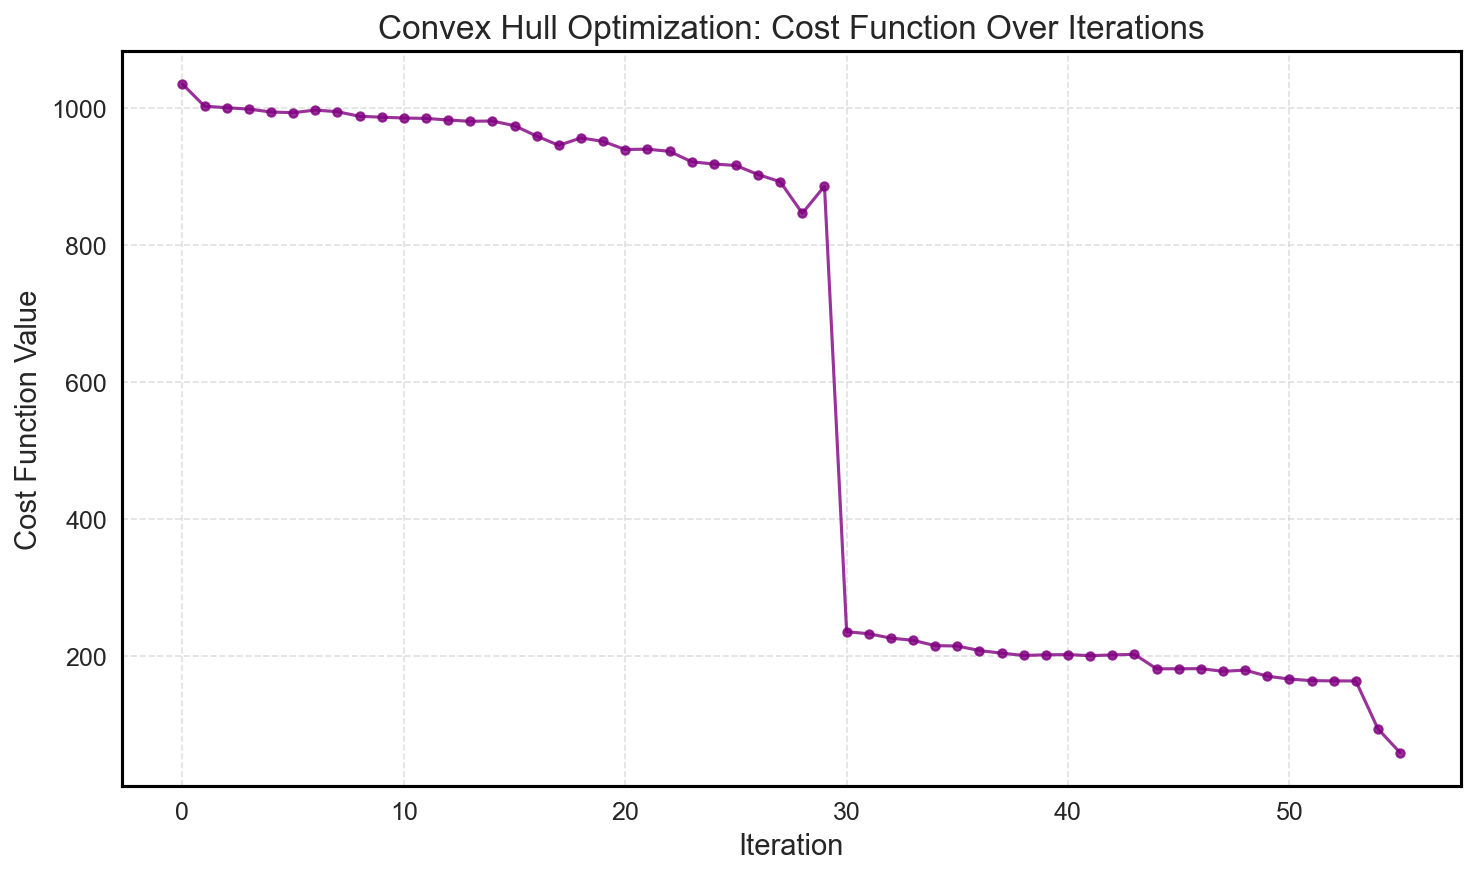

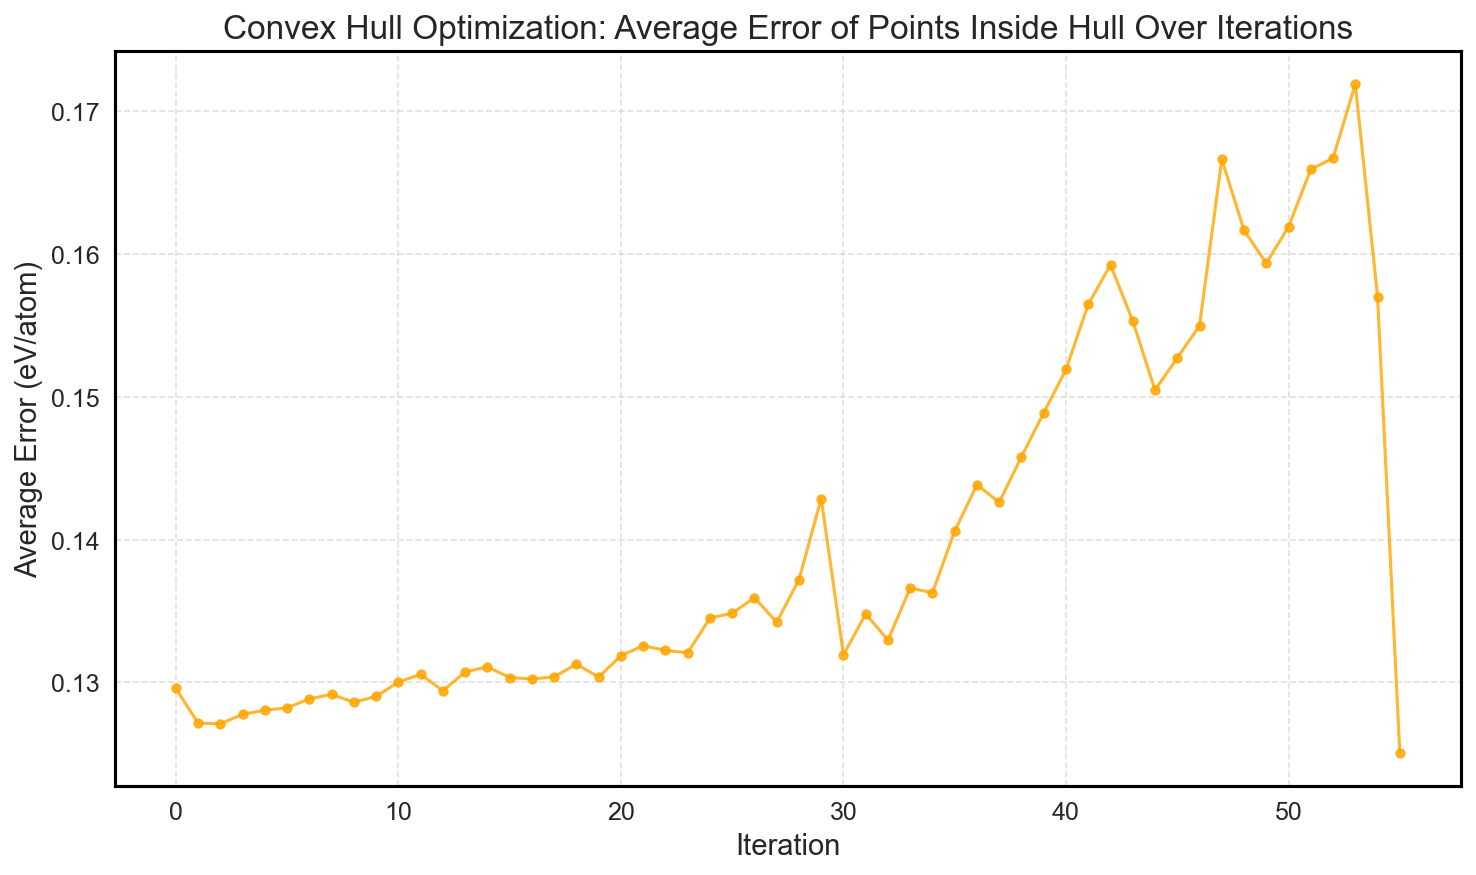

In [11]:
print("\n--- Optimization Progress Visualizations ---")

if len(cost_history) > 1: # Only plot if there's more than one data point
    # 10.1 Plot Cost History over Iterations
    plt.figure(figsize=(10, 6))
    plt.plot(cost_history, marker='o', linestyle='-', color='purple', markersize=4, alpha=0.8)
    plt.title('Convex Hull Optimization: Cost Function Over Iterations', fontsize=16)
    plt.xlabel('Iteration', fontsize=14)
    plt.ylabel('Cost Function Value', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

    # 10.2 Plot Average Error History over Iterations
    plt.figure(figsize=(10, 6))
    plt.plot(error_history, marker='o', linestyle='-', color='orange', markersize=4, alpha=0.8)
    plt.title('Convex Hull Optimization: Average Error of Points Inside Hull Over Iterations', fontsize=16)
    plt.xlabel('Iteration', fontsize=14)
    plt.ylabel('Average Error (eV/atom)', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
else:
    print("Not enough data points to plot optimization history (less than 2 iterations).")

Final Results Plotting Function

In [12]:
print("\n--- Final Results Plotting ---")

def plot_final_results(train_data_for_hull, test_data_for_hull, hull_object):
    """
    Generates plots to visualize the results of the Convex Hull analysis,
    specifically focusing on the relationship between hull distance and prediction error,
    and the distribution of errors for points inside vs. outside the hull.

    Args:
        train_data_for_hull (np.array): The training data used to define the final hull.
                                        Used for calculating error percentiles.
        test_data_for_hull (np.array): The test data, used to evaluate hull distances
                                       and corresponding prediction errors.
        hull_object (scipy.spatial.ConvexHull): The final ConvexHull object.
    """
    if hull_object is None:
        print("Cannot generate final plots: ConvexHull object is None.")
        return

    # Extract relevant columns from test_data_for_hull:
    # - The last 5 columns are PCA components (used for hull distance calculation)
    # - The 8th column from the end is the absolute prediction error
    # The structure is assumed to be: [..., original_features, prederror, y_test, y_predicted, pca_comp1, ..., pca_comp5]
    pca_components_test = test_data_for_hull[:, -5:]
    absolute_prediction_error_test = test_data_for_hull[:, -8]

    # Calculate hull distances for each point in the test set.
    # A positive distance indicates the point is outside the hull.
    distances = []
    for point_pca in pca_components_test:
        # For each point, calculate its signed distance to all hyperplanes of the hull.
        # The maximum of these distances indicates how far outside the hull the point is.
        max_dist = np.max(np.dot(hull_object.equations[:, :-1], point_pca) + hull_object.equations[:, -1])
        distances.append(max_dist)
    distances = np.array(distances)

    # 11.1 Plot: Convex Hull Distance vs. Absolute Prediction Error
    plt.figure(figsize=(10, 6))
    plt.scatter(distances, absolute_prediction_error_test, alpha=0.7, edgecolors='w',
                linewidth=0.5, color='darkcyan', s=50) # Increased marker size for visibility
    plt.title('Convex Hull Distance vs. Absolute Prediction Error', fontsize=16)
    plt.xlabel('Convex Hull Distance', fontsize=14)
    plt.ylabel('Absolute Prediction Error (eV/atom)', fontsize=14)

    # Enhance grid and ticks for better readability
    ax = plt.gca()
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.tick_params(which='major', direction='in', length=6, width=1.5, colors='gray')
    ax.tick_params(which='minor', direction='in', length=4, width=1, colors='gray')

    # Set major and minor tick locators for x and y axes
    ax.xaxis.set_major_locator(MultipleLocator(0.01))
    ax.yaxis.set_major_locator(MultipleLocator(0.1))
    ax.xaxis.set_minor_locator(MultipleLocator(0.005))
    ax.yaxis.set_minor_locator(MultipleLocator(0.05))

    # Set plot limits as per original code for consistency
    plt.xlim(-0.017, 0.05)
    ax.set_facecolor('white') # Ensure white background
    for spine in ax.spines.values(): # Make plot borders black and slightly thicker
        spine.set_color('black')
        spine.set_linewidth(1.5)

    plt.tight_layout()
    plt.show()

    # 11.2 Plot: Error Distribution Based on Convex Hull Position
    # Categorize points based on their distance to the hull boundary:
    # - 'Inside/On Hull Boundary': Distance <= a small tolerance
    # - 'Slightly Outside Hull': Distance > tolerance, but within lower percentile of positive distances
    # - 'Moderately Outside Hull': Distance in the middle percentile of positive distances
    # - 'Far Outside Hull': Distance in the upper percentile of positive distances

    tolerance_for_boundary = 1e-9 # Numerical tolerance for points on the boundary
    errors_inside = [absolute_prediction_error_test[i] for i in range(len(distances))
                     if distances[i] <= tolerance_for_boundary]
    errors_outside_raw = [absolute_prediction_error_test[i] for i in range(len(distances))
                          if distances[i] > tolerance_for_boundary]
    positive_distances = distances[distances > tolerance_for_boundary]

    err_edge_outer = []
    err_mid_outer = []
    err_far_outer = []

    if len(positive_distances) > 0:
        # Define thresholds for 'slightly', 'moderately', 'far' outside based on percentiles
        q1 = np.percentile(positive_distances, 33)
        q2 = np.percentile(positive_distances, 66)

        err_edge_outer = [absolute_prediction_error_test[i] for i in range(len(distances))
                          if distances[i] > tolerance_for_boundary and distances[i] <= q1]
        err_mid_outer = [absolute_prediction_error_test[i] for i in range(len(distances))
                         if distances[i] > q1 and distances[i] <= q2]
        err_far_outer = [absolute_prediction_error_test[i] for i in range(len(distances))
                         if distances[i] > q2]

    plt.figure(figsize=(10, 6))

    # Plot Kernel Density Estimates for each category
    if errors_inside:
        sns.kdeplot(data=errors_inside, color='red', label='Inside/On Hull Boundary', lw=3, fill=True, alpha=0.2)
    if err_edge_outer:
        sns.kdeplot(data=err_edge_outer, color='blue', label='Slightly Outside Hull', lw=3, fill=True, alpha=0.2)
    if err_mid_outer:
        sns.kdeplot(data=err_mid_outer, color='green', label='Moderately Outside Hull', lw=3, fill=True, alpha=0.2)
    if err_far_outer:
        sns.kdeplot(data=err_far_outer, color='purple', label='Far Outside Hull', lw=3, fill=True, alpha=0.2)

    # Add a vertical line indicating the 5th percentile error from the hull training data
    xrline = np.percentile(train_data_for_hull[:, -8], 5)
    plt.axvline(x=xrline, color='darkorange', linestyle='--',
                label=f'5th Percentile Error (Train Hull): {xrline:.4f}')

    plt.title('Error Distribution Based on Convex Hull Position', fontsize=16)
    plt.xlim(0.0, 1.0) # Set x-axis limit for error
    ax = plt.gca()
    ax.set_facecolor('white') # Ensure white background
    for spine in ax.spines.values(): # Make plot borders black and slightly thicker
        spine.set_color('black')
        spine.set_linewidth(1.5)

    plt.legend(loc='upper right', shadow=True, fontsize=12)
    plt.xlabel('Absolute Prediction Error (eV/atom)', fontsize=14)
    plt.ylabel('Density', fontsize=14)
    plt.tight_layout()
    plt.show()


--- Final Results Plotting ---


Execute Final Plotting

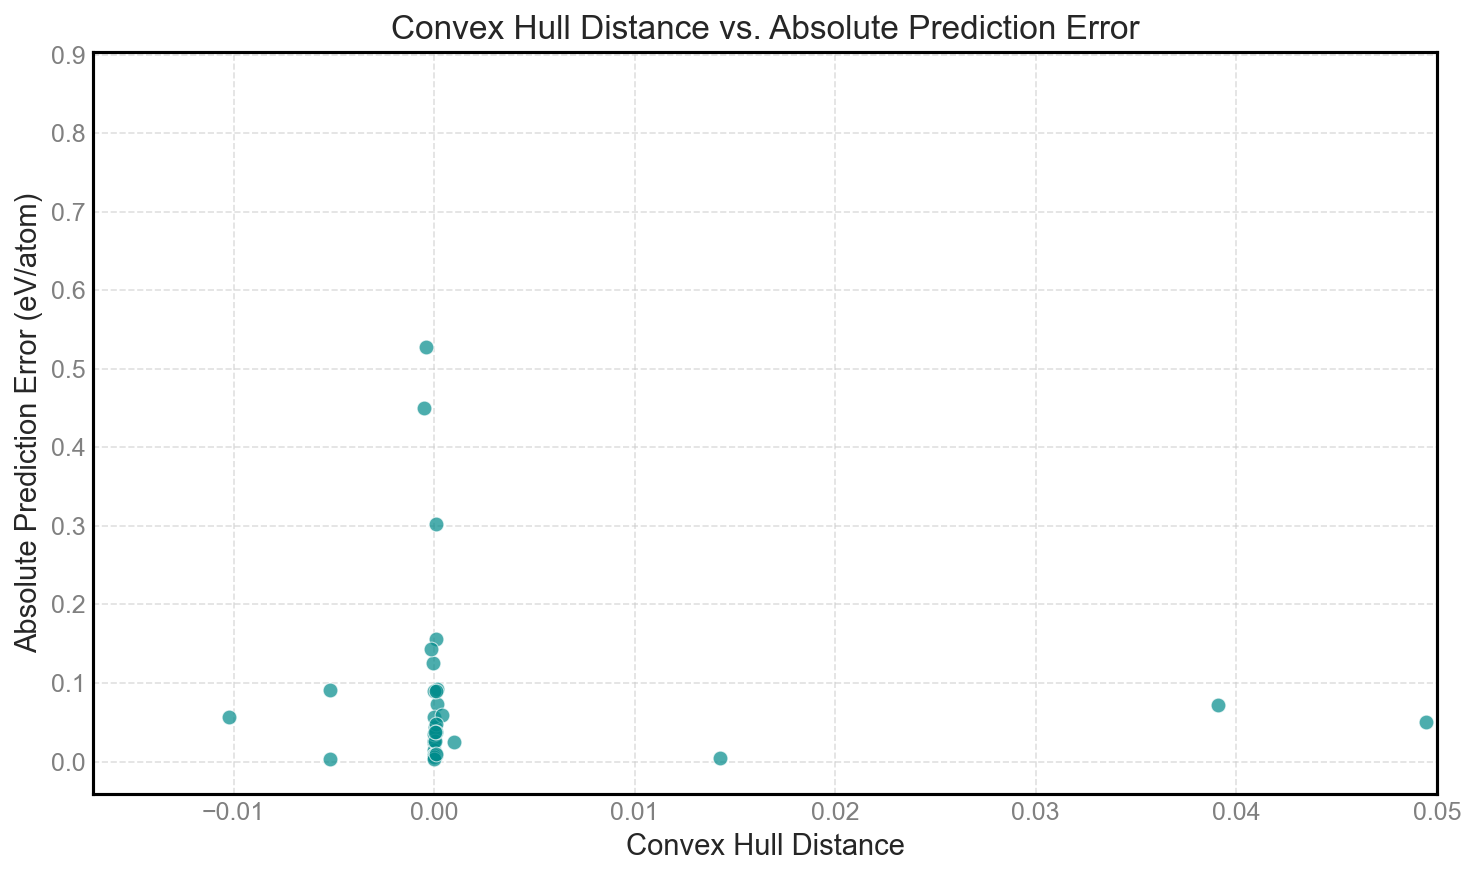

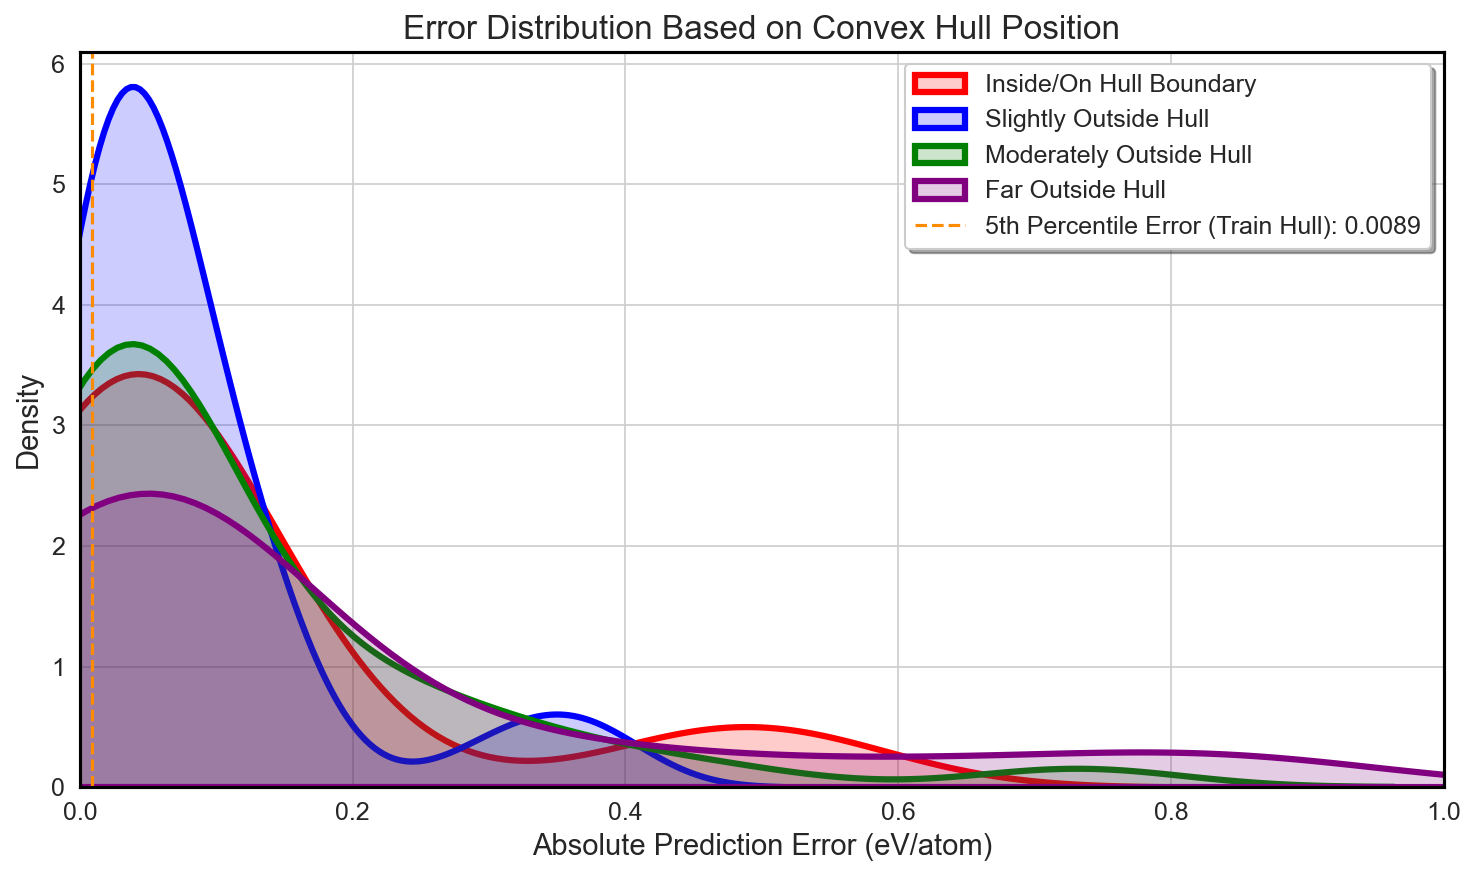


All analyses and visualizations complete.


In [13]:
# Call the plotting function with the results from the optimization
plot_final_results(train_data_for_hull, test_data_for_hull, final_hull_obj)

print("\nAll analyses and visualizations complete.")

Algorithmic Complexity Discussion (Markdown)

# ### Algorithmic Complexity Analysis

# Understanding the algorithmic complexity (Big O notation) of different parts of the code helps in predicting how the runtime will scale with increasing input size.

# Let $N$ be the number of samples (rows) in your dataset and $D$ be the number of features (columns).

# 1.  **Data Loading and Preprocessing (Cell 3):**
#     * `pd.read_csv()`: Generally $O(N \cdot D)$ in the worst case, as it reads all data.
#     * Dropping columns and separating X/y: $O(N \cdot D)$.
#     * `StandardScaler().fit_transform()`: For $N$ samples and $D$ features, this is $O(N \cdot D)$.

# 2.  **SVR Model Training and Prediction (Cell 5):**
#     * `GridSearchCV` with `SVR`: This is the most computationally intensive part.
#         * `SVR` training complexity with an RBF kernel is typically between $O(N_{train}^2 \cdot D)$ and $O(N_{train}^3 \cdot D)$ in the worst case, depending on the number of support vectors.
#         * `GridSearchCV` performs `cv` (cross-validation folds) fittings. So, the complexity is approximately $O(\text{num_param_combinations} \cdot \text{cv} \cdot N_{train}^2 \cdot D)$.
#         * Prediction: $O(N_{test} \cdot D \cdot N_{support\_vectors})$.

# 3.  **PCA Transformation (Cell 7):**
#     * `PCA.fit()`: The singular value decomposition (SVD) used in PCA typically has a complexity of $O(\min(D, N_{train}) \cdot D \cdot N_{train})$ or $O(D^2 \cdot N_{train})$ if $D < N_{train}$.
#     * `PCA.transform()`: $O(N \cdot D \cdot k)$, where $k$ is the number of components.

# 4.  **Convex Hull Optimization (`optimize_hull` function in Cell 8):**
#     * The `ConvexHull` computation itself is a complex geometric algorithm. For $N$ points in $d$ dimensions (here, $d=5$ PCA components), the worst-case complexity is roughly $O(N^{\lfloor d/2 \rfloor} + N \log N)$ or $O(N \log N)$ for fixed small $d$. Given $d=5$, it's closer to $O(N^2)$.
#     * The `optimize_hull` function runs for `n_iterations` (e.g., 2000). In each iteration, it:
#         * Performs `train_test_split`: $O(N)$.
#         * Calculates `ConvexHull`: $O(N_{subset}^2)$ where $N_{subset}$ is the number of points used for the hull in that iteration.
#         * Iterates through `len(trainconvexhull)` points and calls `point_in_hull` for each.
#         * `point_in_hull` involves dot products with `hull.equations`. If `hull` has $F$ facets, this is $O(F \cdot d)$. The number of facets $F$ can be up to $O(N_{subset}^{\lfloor d/2 \rfloor})$.
#     * Therefore, the overall complexity of `optimize_hull` is roughly $O(\text{n_iterations} \cdot (N_{subset}^2 + N \cdot F \cdot d))$. This can be quite high due to the iterative hull calculations and point-in-hull checks.

# ### Practical Runtime Measurement

# While theoretical complexity provides a general understanding, actual runtime depends on constants, hardware, and specific data characteristics. The following cell will measure the execution time of the main parts of the script.


--- Measuring Runtime Complexity ---
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Time taken for SVR training and prediction: 10.1420 seconds
Time taken for Data Stacking and PCA Transformation: 0.0056 seconds
Starting Convex Hull optimization for up to 2000 iterations...
Iteration 0: Current Cost = 1034.79, Current Avg Error = 0.1296, Points in Hull = 480
Early stopping: Error within acceptable range and enough points (65) at iteration 55.
Time taken for Convex Hull Optimization: 47.7567 seconds


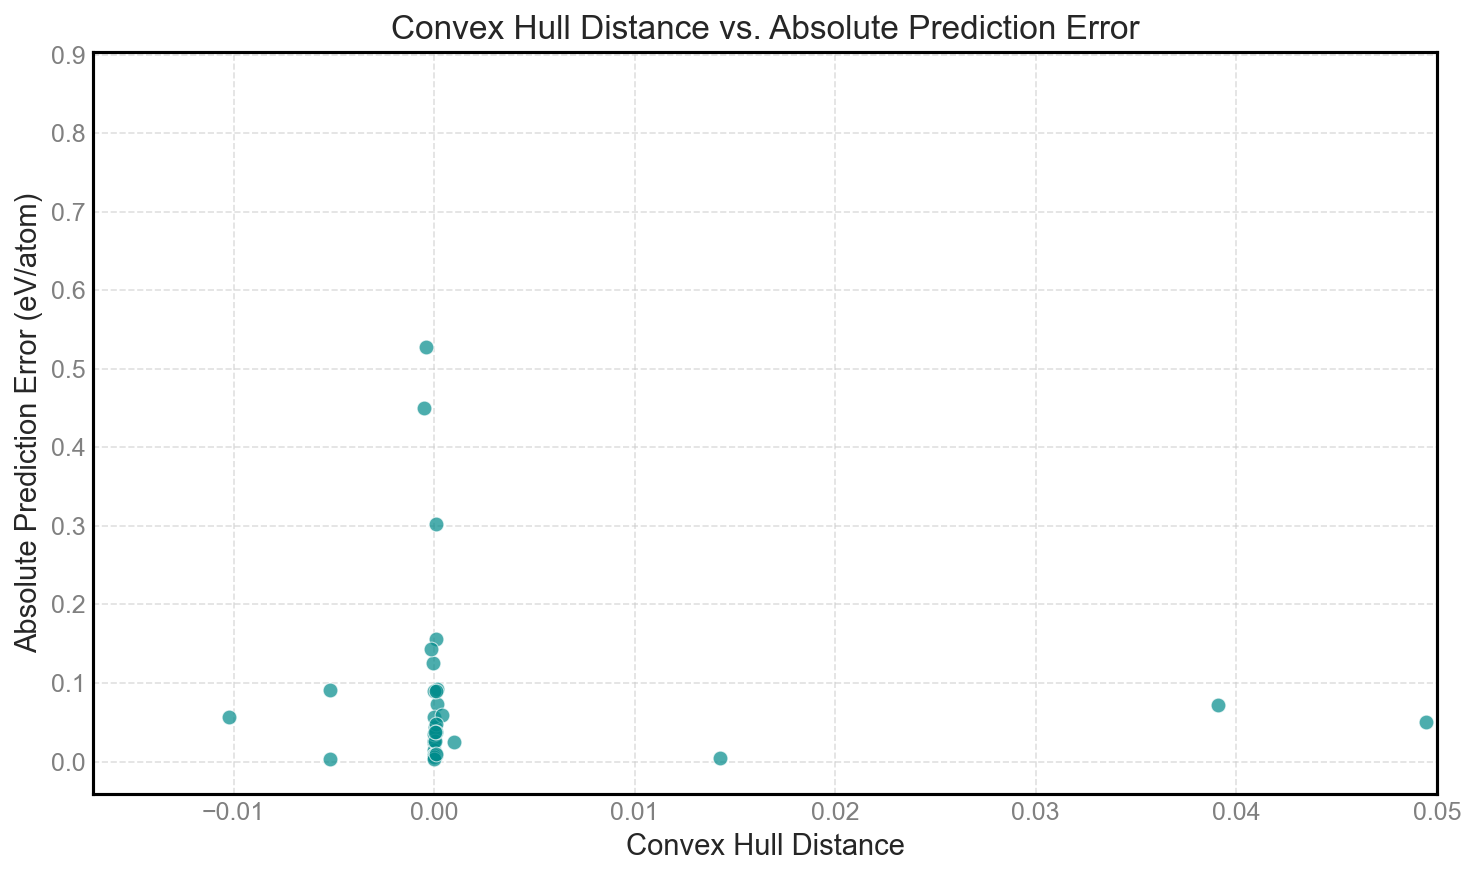

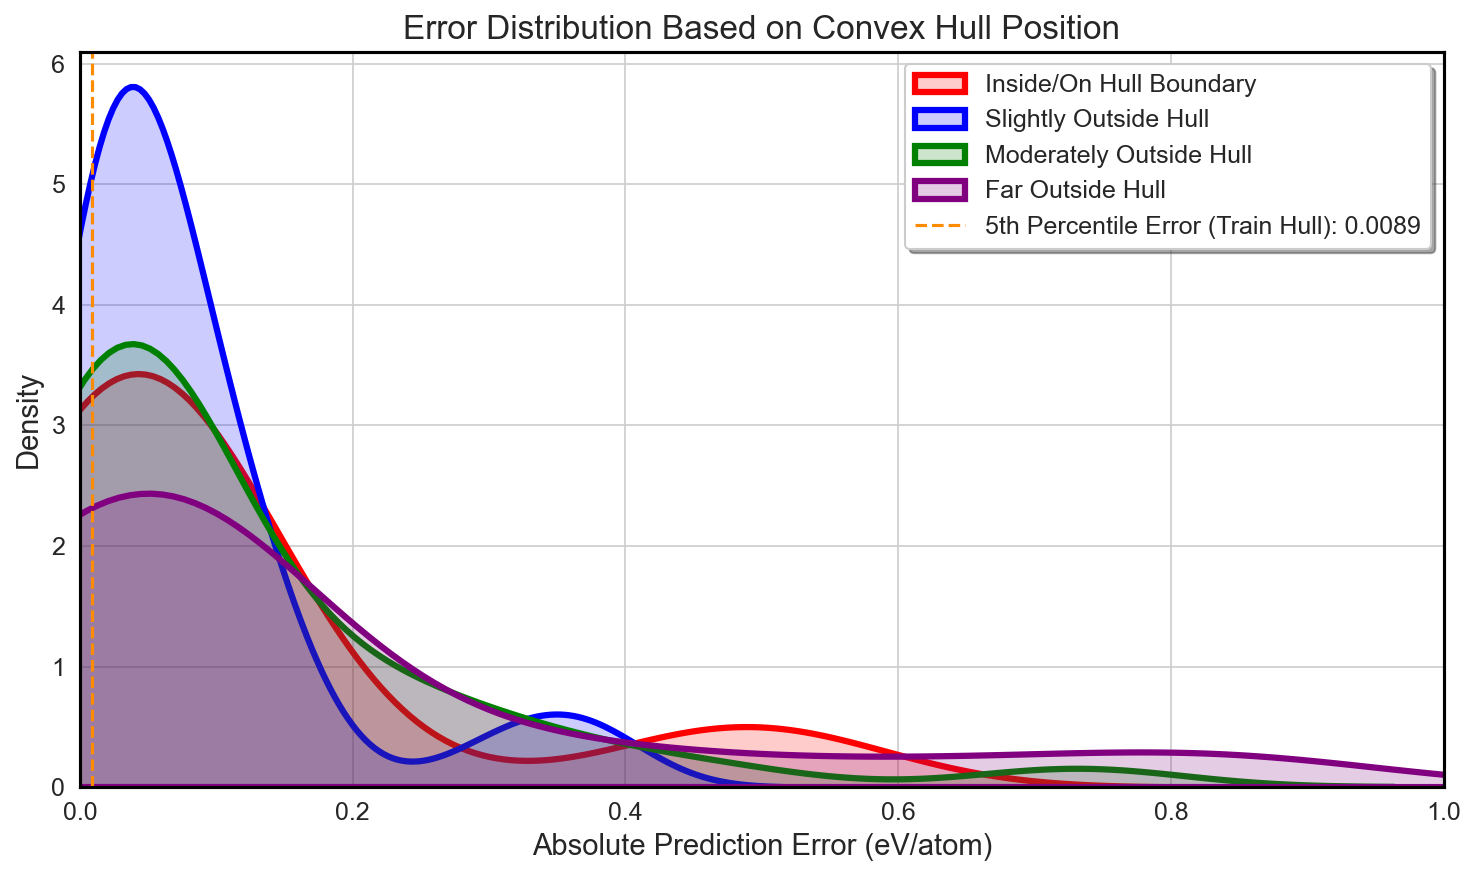

Time taken for Final Results Plotting: 0.6036 seconds

Runtime measurement complete.


In [14]:
# Runtime Complexity Measurement

import time

print("\n--- Measuring Runtime Complexity ---")

# Measure time for SVR training and prediction
start_time_svr = time.time()
# Re-running SVR training and prediction for measurement purposes
# (These steps are already executed in Cell 5, but re-run here for isolated timing)
grid.fit(X_train_raw, y_train)
y_predicted = grid.predict(X_test_raw)
prederror = np.abs(y_predicted - y_test)
end_time_svr = time.time()
print(f"Time taken for SVR training and prediction: {end_time_svr - start_time_svr:.4f} seconds")

# Measure time for Data Stacking and PCA Transformation
start_time_pca = time.time()
scaler_for_pca_features = StandardScaler()
X_train_scaled_for_pca = scaler_for_pca_features.fit_transform(X_train_raw)
X_test_scaled_for_pca = scaler_for_pca_features.transform(X_test_raw)
stack1 = np.vstack((X_test_scaled_for_pca.T, prederror, y_test, y_predicted))
trainconvexhull10 = stack1.T
pca_on_features = PCA(n_components=5, random_state=RANDOM_SEED)
pca_on_features.fit(X_train_scaled_for_pca)
pca_transformed_test_features = pca_on_features.transform(X_test_scaled_for_pca)
trainconvexhullFint = np.hstack((trainconvexhull10, pca_transformed_test_features))
trainconvexhullF = np.random.RandomState(RANDOM_SEED).permutation(trainconvexhullFint)
end_time_pca = time.time()
print(f"Time taken for Data Stacking and PCA Transformation: {end_time_pca - start_time_pca:.4f} seconds")


# Measure time for Convex Hull Optimization
start_time_hull_opt = time.time()
# The optimize_hull function is called here, using the data prepared above
train_data_for_hull, test_data_for_hull, final_hull_obj, cost_history, error_history = optimize_hull(trainconvexhullF)
end_time_hull_opt = time.time()
print(f"Time taken for Convex Hull Optimization: {end_time_hull_opt - start_time_hull_opt:.4f} seconds")

# Measure time for Final Results Plotting
start_time_plotting = time.time()
plot_final_results(train_data_for_hull, test_data_for_hull, final_hull_obj)
end_time_plotting = time.time()
print(f"Time taken for Final Results Plotting: {end_time_plotting - start_time_plotting:.4f} seconds")

print("\nRuntime measurement complete.")